# Import

In [2]:
# configure path to include the python files
import sys, os, subprocess

nb_path = !pwd
nb_path = nb_path[0]

# cd to the h264-extractor folder
lib_path = os.path.abspath(os.path.join(nb_path, 'h264-extractor', 'openh264', 'info_shipout'))
if lib_path not in sys.path:
    sys.path.append(lib_path)

# import slice (check h264 standard) proto
from slice_pb2 import Slice

# locate h264 extractor binary file
bin_path = os.path.abspath(os.path.join(nb_path, 'h264-extractor', 'bin'))
h264_ext_bin = os.path.join(bin_path, 'h264dec_ext_info')
if not os.path.exists(h264_ext_bin):
    raise FileNotFoundError(f'cannot locate the binary file "{h264_ext_bin}", was it built?')


# Extract encoding parameters

In [3]:
# locate video file
video_filename = os.path.join(nb_path, 'h264-extractor', 'example', 'bunny.mp4')
if not os.path.exists(video_filename):
    raise FileNotFoundError(f'cannot locate the video file "{video_filename}"')
h264_filename = os.path.join(nb_path, os.path.splitext(video_filename)[0] + '.h264')

# extract h264 from the mp4 file using ffmpeg
cp = subprocess.run(
        ['ffmpeg', '-y', '-i', video_filename, '-vcodec', 'copy', '-an', 
        '-bsf:v', 'h264_mp4toannexb', h264_filename],
        check=True
    )

# use the extractor to acquire encoding parameters
yuv_filename = os.path.join(nb_path, 'bunny.yuv') # YUV frames
ep_filename = os.path.join(nb_path, 'bunny.msg') # encoding parameters

cp = subprocess.run(
        [h264_ext_bin, h264_filename, '--yuv_out', yuv_filename, '--info_out', ep_filename, '--n_threads', '0'],
        # for now, only setting threads to 0 is allowed; using other values can result in 
        # unexpected behaviors
        check=True
    )

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

------------------------------------------------------


-------------------------------------------------------
iWidth:		1280
height:		720
Frames:		300
decode time:	2.135787 sec
FPS:		140.463445 fps
-------------------------------------------------------


In [4]:
# read YUV and encoding parameters
import struct
import os
import skimage.transform, skimage.color
import numpy as np

def get_ep_file_iterator(filename):
    with open(filename, 'rb') as file:
        file_size = os.stat(filename).st_size
        while file.tell() < file_size:
            length_bytes = file.read(4)
            # Interpret data as little-endian unsigned int to convert from C layer to Python
            length = struct.unpack('<I', length_bytes)[0]
            yield file.read(length)

def read_ep(filename):
    iterator = get_ep_file_iterator(filename)
    for bytes in iterator:
        slice = Slice()
        slice.ParseFromString(bytes)
        yield slice


def rgb_from_yuv(width, height, frame_num, yuv_filename):
    """Reads an RGB frame from a YUV file.

    Args:
        width (_type_): width of the source yuv video
        height (_type_): height of the source yuv video
        frame_num (_type_): index of the desired frame
        filename (_type_): filename of the yuv file

    Returns:
        _type_: RGB frame
    """
    
    # In YUV420 format, each pixel of the Y (luma) component is represented by 1 byte, while the U and V (chroma) components are subsampled, so each of them is represented by 0.25 bytes. Hence, the total size is (width * height * 1.5).
    frame_size = int(width * height * 1.5)
    
    # Color space conversion constants
    U_MAX = 0.436
    V_MAX = 0.615

    with open(yuv_filename, 'rb') as file:
        # Read the frame at the specified frame number
        file.seek(frame_num * frame_size)
        
        y = np.frombuffer(file.read(width * height), dtype=np.uint8).reshape((height, width))
        u = np.frombuffer(file.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))
        v = np.frombuffer(file.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))

        # Rescale subsampled chroma components to the same size as the luma component
        y = skimage.img_as_float32(y)
        u = skimage.transform.rescale(u, 2.0, 1, anti_aliasing=False)
        v = skimage.transform.rescale(v, 2.0, 1, anti_aliasing=False)

        # Color space conversion
        u = (u * 2 * U_MAX) - U_MAX
        v = (v * 2 * V_MAX) - V_MAX

        # Convert to RGB
        yuv = np.dstack([y, u, v])
        rgb = skimage.color.yuv2rgb(yuv)
    return rgb

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np

FRAME_NUM = 2

# create encoding parameters iterator
encoding_parameters_iter = read_ep(ep_filename)
# read the FRAME_NUM-th slice
for _ in range(FRAME_NUM):
    slice = next(encoding_parameters_iter)

# for frame in encoding_parameters_iter:
#     pass

width, height = slice.width, slice.height
# read the second frame
rgb_frame = rgb_from_yuv(width, height, 1, yuv_filename)

{'DESCRIPTOR': <google._upb._message.Descriptor object at 0x7ff7baaefab0>, '__module__': 'slice_pb2', '__slots__': (), '__doc__': None}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Frame 2 decoded')

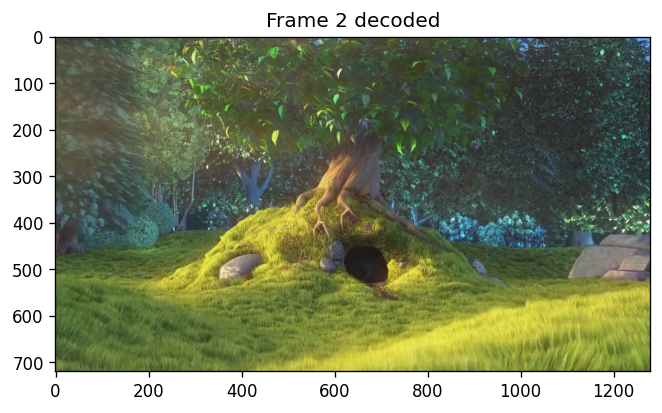

In [6]:
plt.imshow(rgb_frame)
plt.title('Frame {} decoded'.format(FRAME_NUM))

In [15]:
# now, visualize the encoding parameters

# first we need to get the size of the macroblocks from the enums

import re
from slice_pb2 import MacroblockType

# parse the size of macroblocks from the enum names
mb_size_regex = re.compile('([0-9]{1,2})x([0-9]{1,2})')
mb_size_dict = dict()
# Iterate through all the enum entries to build a dictionary of macroblock sizes
for key, val in MacroblockType.items():
    search_result = mb_size_regex.search(key)
    if search_result is not None:
        mb_size_x = int(search_result.group(1))
        mb_size_y = int(search_result.group(2))
        mb_size_dict[key] = (mb_size_x, mb_size_y)
    else:
        mb_size_dict[key] = (16, 16)

# show some entires
for key in list(mb_size_dict.keys())[:10]:
    print(f'{key}={mb_size_dict[key]}')

MB_TYPE_PLACEHOLDER=(16, 16)
MB_TYPE_INTRA4x4=(4, 4)
MB_TYPE_INTRA16x16=(16, 16)
MB_TYPE_INTRA8x8=(8, 8)
MB_TYPE_16x16=(16, 16)
MB_TYPE_16x8=(16, 8)
MB_TYPE_8x16=(8, 16)
MB_TYPE_8x8=(8, 8)
MB_TYPE_8x8_REF0=(8, 8)
MB_TYPE_SKIP=(16, 16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Macroblock Partition and Type')

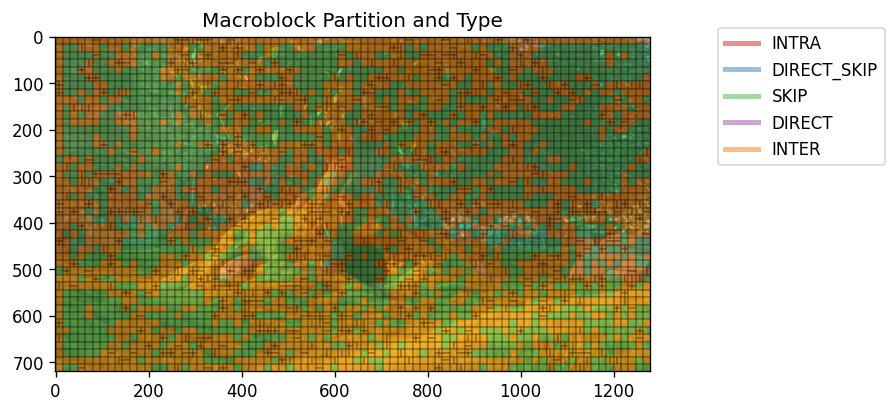

In [8]:
# now, begin the visualization
plt.imshow(rgb_frame)
ax = plt.gca()

mb_color_cycle = plt.get_cmap('Set1')
mb_alpha = 0.5
mb_colors = np.asarray([mb_color_cycle(i) for i in range(5)])
mb_colors[:, 3] = mb_alpha
mb_labels = ['INTRA', 'DIRECT_SKIP', 'SKIP', 'DIRECT', 'INTER']
line_color = 'black'
line_width = 0.2

for mb in slice.mbs:
    mb_type = MacroblockType.Name(mb.type)
    mb_size = mb_size_dict[mb_type]

    mb_label_index = None

    # determine the color
    if 'INTRA' in mb_type:
        mb_label_index = 0
    elif 'SKIP' in mb_type and 'DIRECT' in mb_type:
        mb_label_index = 1
    elif 'SKIP' in mb_type:
        mb_label_index = 2
    elif 'DIRECT' in mb_type:
        mb_label_index = 3
    else:
        mb_label_index = 4

    color = mb_colors[mb_label_index]
    
    # compute the lower left corner of the macroblock
    mb_x = mb.x * 16
    mb_y = mb.y * 16

    patches = []

    if mb_size == (16, 16):
        patches.append(Rectangle((mb_x, mb_y), 16, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (8, 16):
        patches.append(Rectangle((mb_x, mb_y), 8, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
        patches.append(Rectangle((mb_x + 8, mb_y), 8, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (16, 8):
        patches.append(Rectangle((mb_x, mb_y), 16, 8, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
        patches.append(Rectangle((mb_x, mb_y+8), 16, 8, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (8, 8):
        for i in range(2):
            for j in range(2):
                patches.append(Rectangle((mb_x+i*8, mb_y+j*8), 8, 8, 
                    facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (4,4):
        for i in range(4):
            for j in range(4):
                patches.append(Rectangle((mb_x+i*4, mb_y+j*4), 4, 4, 
                    facecolor=color, edgecolor=line_color, linewidth=line_width))
    else:
        raise ValueError(f'unsupported macroblock size {mb_size}')

    for patch in patches:
        ax.add_patch(patch)

# generate the legend
custom_legends = [Line2D([0], [0], color=x, lw=3) for x in mb_colors]
plt.legend(custom_legends, mb_labels, bbox_to_anchor=(1.1, 1.05))
plt.title('Macroblock Partition and Type')